In [1]:
# imports
import numpy as np
import tensorflow as tf
from tqdm import tqdm
from random import shuffle
import matplotlib.pyplot as plt
from scipy.stats import norm

In [2]:
# define number of basis functions and batch size
NUM_FEATURES = 5
BATCH_SIZE = 32
NUM_BATCHES = 300

In [3]:
# function for plotting a sine wave on the domain (0,1)
def plotTruth(ax):
    
    x = np.linspace(0,1)
    y = np.sin(2*np.pi*x)
    ax.plot(x, y, label='ground truth')
    
    return ax

In [4]:
# data class initializes (x,y) pairs and contains get_batch function to pull samples of data
class Data(object):
    def __init__(self):
        num_samp = 50
        sigma = 0.1
        np.random.seed(12345)

        self.index = np.arange(num_samp)
        self.x = np.random.uniform(size=(num_samp))
        self.y = np.sin(2*np.pi*self.x) + np.random.normal(0,sigma,num_samp)
        
    def get_batch(self):
        choices = np.random.choice(self.index, size=BATCH_SIZE)
        
        return self.x[choices], self.y[choices].flatten()
    
# f(x) defines our parameters and returns our predictors 
def f(x):
    w = tf.get_variable('w', [NUM_FEATURES,1], tf.float32, tf.random_normal_initializer())
    mu = tf.get_variable('mu', [NUM_FEATURES,1], tf.float32, tf.random_uniform_initializer())
    sig = tf.get_variable('sig', [NUM_FEATURES,1], tf.float32, tf.random_normal_initializer())
    b = tf.get_variable('b', [], tf.float32, tf.zeros_initializer())
    
    return tf.squeeze(tf.matmul(tf.transpose(w),tf.exp(-tf.pow(x-mu, 2)/tf.pow(sig,2))) + b)

# initialize placeholders for x and y batches
x = tf.placeholder(tf.float32, [BATCH_SIZE])
y = tf.placeholder(tf.float32, [BATCH_SIZE])
y_hat = f(x)

# define loss function and reduce mean to get a scalar
loss = tf.reduce_mean((1/2)*tf.pow(y_hat - y, 2))

# gradient descent to optimize our parameters by minimizing our loss function
optim = tf.train.GradientDescentOptimizer(learning_rate=0.1).minimize(loss)
init = tf.global_variables_initializer()

sess = tf.Session()
sess.run(init)

data = Data()

# loop through batches and run gradient descent to tune our parameters
for _ in tqdm(range(0, NUM_BATCHES)):
    x_np, y_np = data.get_batch()
    loss_np, _ = sess.run([loss, optim], feed_dict={x: x_np, y:y_np})
    
print("Parameter estimates: ")
learned = []

# print out parameters and collect mu and sigma for plotting
for var in tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES):
    print (
        var.name.rstrip(":0"),
        np.array_str(np.array(sess.run(var)).flatten(),precision=3))
    
    if var.name.rstrip(":0") == "mu" or var.name.rstrip(":0") == "sig":
        learned.append(np.array(sess.run(var)).flatten().tolist())

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:00<00:00, 1144.14it/s]


Parameter estimates: 
w [-1.049  0.148  0.381  0.074  0.848]
mu [0.731 0.691 0.101 0.22  0.267]
sig [-0.179  1.89   0.786  2.527 -0.172]
b [-0.421]


In [5]:
# function for plotting the gaussian basis functions
def plotGaus(learned, ax):
    
    for i in range(0,NUM_FEATURES):
        x = np.linspace(0,1)
        y = np.exp(-((x-learned[0][i])/learned[1][i])**2)
        ax.plot(x, y)
    
    return ax

In [6]:
# function for plotting the prediction of our linear regression
def plotPred(x_vals, ax):
    
    yhat = sess.run(y_hat, feed_dict={x:x_vals})
    
    ax.plot(x_vals, yhat, label='prediction')
    
    return ax

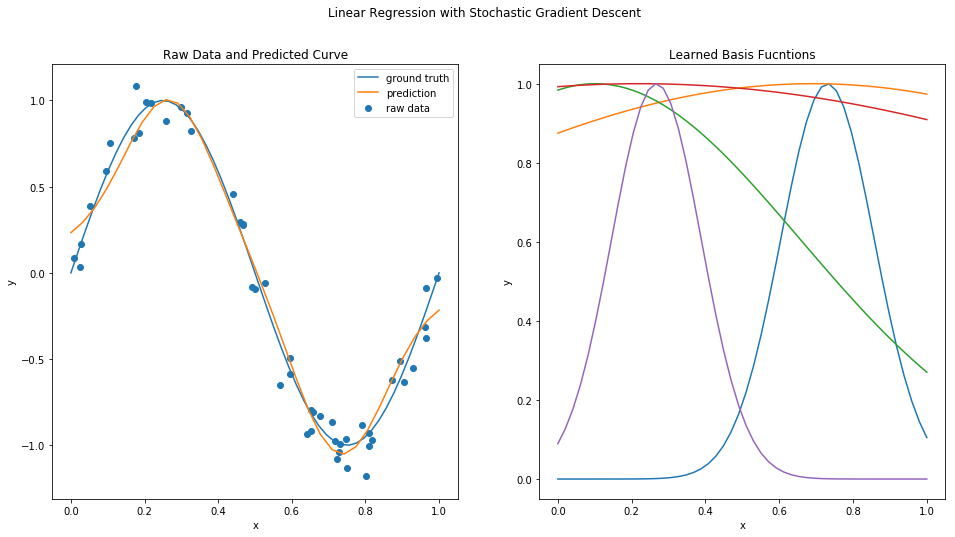

In [7]:
# initialize figure
fig, axarr = plt.subplots(nrows=1, ncols=2, figsize=[16,8])

plotTruth(axarr[0])
axarr[0].scatter(data.x, data.y, label='raw data')

plotGaus(learned, axarr[1])

x_vals = np.linspace(0,1,32)
plotPred(x_vals, axarr[0])

# pretty plots for Curro
fig.suptitle('Linear Regression with Stochastic Gradient Descent')
axarr[0].set_title('Raw Data and Predicted Curve')
axarr[1].set_title('Learned Basis Fucntions')

axarr[0].set(xlabel='x', ylabel='y')
axarr[1].set(xlabel='x', ylabel='y')

axarr[0].legend()

plt.show()